# Pavli et al. Dump Cooled Engine

Comparison with data for test firing 9, from Pavli's dump-cooled engine paper.


### References:

- [1] - Pavli et al. 1966, Design and Cooling Performance of a Dump-Cooled Rocket Engine (https://ntrs.nasa.gov/citations/19660022898)

In [16]:
import bamboo as bam
import pypropep as ppp
from CoolProp.CoolProp import PropsSI
import cantera as ct
import matplotlib.pyplot as plt
import numpy as np
import json

data = json.load(open("data/pavli.json"))

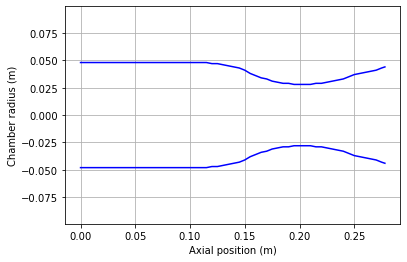

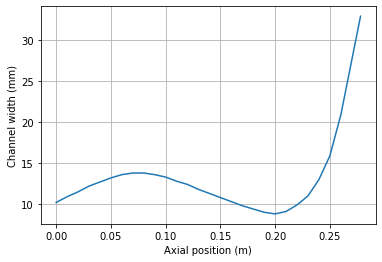

In [17]:
# Combustion chamber (firing 9) [1]
OF = 5.01
p0_chamber = 7.91e5
T0_chamber = 2939

xs = data["Chamber Contour"]["x (m)"]
ys = data["Chamber Contour"]["y (m)"]

# Cooling channels [1]
wall_thickness = 2.54e-3
wall_material = bam.materials.StainlessSteel304
number_of_channels = 8
mdot_coolant = 0.0644
p0_coolant_in = data["Coolant static pressure"]["p (Pa)"][0] # Designed for 10.3e5 Pa
T_coolant_in = data["Coolant temperature"]["T (K)"][0]       # Designed for 31.7 K
channel_height = 2.54e-3

def channel_width(x):
    return np.interp(x, data["Channel width"]["x (m)"], data["Channel width"]["w (m)"])

def blockage_ratio(x):
    area = channel_width(x) * channel_height
    return 2.045e-6 / area
    
plt.plot(xs, ys, color = 'blue')
plt.plot(xs, -np.array(ys), color = 'blue')
plt.grid()
plt.xlabel("Axial position (m)")
plt.ylabel("Chamber radius (m)")
plt.axis('equal')
plt.show()

plt.plot(xs, 1e3 * channel_width(xs))
plt.grid()
plt.xlabel("Axial position (m)")
plt.ylabel("Channel width (mm)")
plt.show()

In [18]:
# Cantera for exhaust gas
gas = ct.Solution('gri30.yaml')
gas.TPY = T0_chamber, p0_chamber, f"H2:{1}, O2:{OF}"
gas.equilibrate("TP")

cp = gas.cp
gamma = cp / gas.cv

def mu_exhaust(T, p):
    gas.TP = T, p
    return gas.viscosity

def k_exhaust(T, p):
    gas.TP = T, p
    return gas.thermal_conductivity

def Pr_exhaust(T, p):
    gas.TP = T, p
    return gas.cp * gas.viscosity / gas.thermal_conductivity

In [19]:
# CoolProp for coolant transport properties
def Pr_coolant(T, p):
    return PropsSI("PRANDTL", "T", T, "P", p, "HYDROGEN")

def mu_coolant(T, p):
    return PropsSI("VISCOSITY", "T", T, "P", p, "HYDROGEN")

def k_coolant(T, p):
    return PropsSI("CONDUCTIVITY", "T", T, "P", p, "HYDROGEN")

def cp_coolant(T, p):
    return PropsSI("CPMASS", "T", T, "P", p, "HYDROGEN") 

def rho_coolant(T, p):
    return PropsSI("DMASS", "T", T, "P", p, "HYDROGEN") 

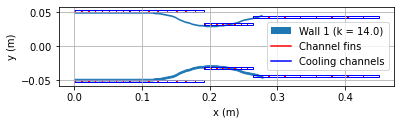

In [20]:
# Set up everything for bamboo
geometry = bam.Geometry(xs = xs, 
                        ys = ys)

perfect_gas = bam.PerfectGas(gamma = gamma, 
                             cp = cp)   

chamber_conditions = bam.ChamberConditions(p0 = p0_chamber, 
                                           T0 = T0_chamber)

exhaust_transport = bam.TransportProperties(Pr = Pr_exhaust,
                                            mu = mu_exhaust,
                                            k = k_exhaust)

coolant_transport = bam.TransportProperties(Pr = Pr_coolant,
                                            mu = mu_coolant,
                                            k = k_coolant,
                                            cp = cp_coolant,
                                            rho = rho_coolant)

cooling_jacket = bam.CoolingJacket(T_coolant_in = T_coolant_in,                           
                                   p0_coolant_in = p0_coolant_in, 
                                   coolant_transport = coolant_transport, 
                                   mdot_coolant = mdot_coolant, 
                                   configuration = "spiral", 
                                   channel_height = channel_height,
                                   channel_width = channel_width,
                                   number_of_channels = number_of_channels,
                                   blockage_ratio = blockage_ratio)

wall = bam.Wall(material = wall_material, 
                thickness = wall_thickness)

engine = bam.Engine(perfect_gas = perfect_gas, 
                    chamber_conditions = chamber_conditions, 
                    geometry = geometry,
                    cooling_jacket = cooling_jacket,
                    exhaust_transport = exhaust_transport,
                    walls = wall)

engine.plot()

In [21]:
# Run simulation
bamboo_data = engine.steady_heating_analysis(counterflow = False)

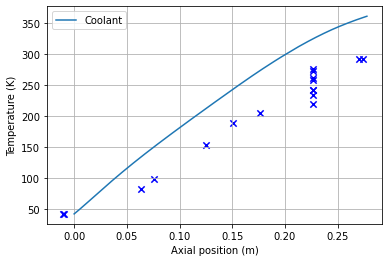

In [22]:
bam.plot.plot_temperatures(bamboo_data, only_indexes = [0])
plt.scatter(data["Coolant temperature"]["x (m)"], 
            data["Coolant temperature"]["T (K)"],
            marker = 'x',
            s = 40,
            color = 'blue')
plt.show()

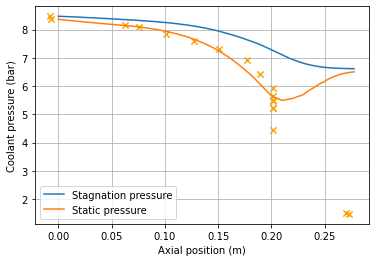

In [23]:
bam.plot.plot_jacket_pressure(bamboo_data)
plt.scatter(data["Coolant static pressure"]["x (m)"], 
            np.array(data["Coolant static pressure"]["p (Pa)"])/1e5,
            marker = 'x',
            s = 40,
            color = 'orange')
plt.show()

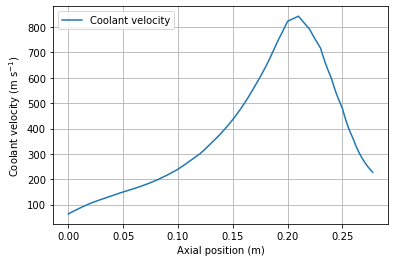

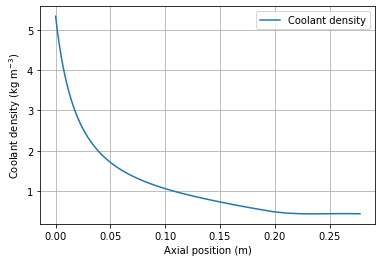

In [24]:
bam.plot.plot_coolant_velocity(bamboo_data)
bam.plot.plot_coolant_density(bamboo_data)

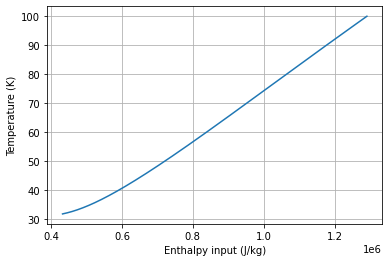

No flat line, so there was no boiling


In [25]:
# Check if the hydrogen was supposed to boil
p = 10e5
H_0 = PropsSI("HMASS", "T", 31.7, "P", p, "HYDROGEN")
H_END = PropsSI("HMASS", "T", 100, "P", p, "HYDROGEN")
H = np.linspace(H_0, H_END, 1000)
T = PropsSI("T", "HMASS", H, "P", p, "HYDROGEN")

plt.plot(H, T)
plt.grid()
plt.xlabel("Enthalpy input (J/kg)")
plt.ylabel("Temperature (K)")
plt.show()

print("No flat line, so there was no boiling")